<a href="https://colab.research.google.com/github/akitim/Ligand_activity_prediction_GlobalAI2022/blob/main/ligand_activity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [25]:
!python -m pip install rdkit-pypi

In [26]:
!pip install catboost

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.SaltRemover import SaltRemover

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Функции

In [59]:
def get_submission_file(clf, data):
    
    X_test = data[data['is_test']].\
        drop(['is_test', 'smiles', 'active'], axis=1)

    submission = data.loc[data['is_test'], ['smiles']].reset_index(drop=True)
    submission['Active'] = clf.predict(X_test)
    submission.columns = ['Smiles', 'Active']

    submission.to_csv('submission.csv')
    return submission

def remove_salt_ions(smiles):

    sr = SaltRemover()
    mol = Chem.MolFromSmiles(smiles)
    result, deleted = sr.StripMolWithDeleted(mol)
    
    result = Chem.MolToSmiles(result)
    deleted = list(map(Chem.MolToSmiles, deleted))

    return result, deleted

## Загружаем данные:

In [60]:
train_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/train.csv'
test_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/test.csv'

train = pd.read_csv(train_path)
# train = pd.read_csv('/content/train.csv')
test = pd.read_csv(test_path)
# test = pd.read_csv('/content/test.csv')

train.sample(5)

,Unnamed: 0,Smiles,Active
2579,2579,CN1CCC(C(=O)c2cccc(NC(=O)c3c(F)cc(F)cc3F)n2)CC1,False
1858,1858,Nc1nc(-c2cccnc2)nn1C(=O)c1ccc(Cl)cc1,False
4968,4968,COc1ccc(N(C(=O)Nc2c(C)cccc2C)c2cc(Nc3ccc(N4CCN...,False
3643,3643,COc1cc(N2CCC(N(C)C)CC2)ccc1Nc1ncc(Cl)c(Nc2cccc...,False
3519,3519,CNCCCC1c2ccccc2C=Cc2ccccc21,False


In [30]:
train = train.loc[:, ['Smiles', 'Active']]
train.columns = ['smiles', 'active']
train['is_test'] = False
# train['active'] = train['active'].astype('int32')

test = test.loc[:, ['Smiles']]
test['active'] = None #pd.NA().nan
test.columns = ['smiles', 'active']
test['is_test'] = True

data = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
data.sample(5)

,smiles,active,is_test
6025,CN1CCc2cc(Cl)c(O)cc2[C@@H](c2ccccc2)C1,None,True
2882,Nc1ccc(F)cc1NC(=O)c1ccc(CNC(=O)/C=C/c2cccnc2)cc1,False,False
2874,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1,False,False
6455,COc1ccc(C(=O)c2ccc(C)cc2)c(O)c1,None,True
2099,Cn1nccc1Nc1nccc(-c2ccn([C@H](CO)c3ccc(Cl)c(F)c...,False,False


In [ ]:
train.shape, test.shape

((5557, 3), (1614, 3))

In [ ]:
active_ind = train.groupby('active').groups[1]
not_active_ind = train.groupby('active').groups[0]
print(f"Active: {active_ind.size}\n\
Not active: {not_active_ind.size}")

Active: 206
Not active: 5351


## Модель 0 (random baseline)

In [ ]:
# submission = test.copy()
# submission['Active'] = (np.random.rand(test.shape[0]) <= 206 / 5351)
# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')


## Предобработка

In [61]:
# deleted_salts = data['smiles'].apply(lambda s: remove_salt_ions(s)[1])
data['smiles'] = data['smiles'].apply(lambda s: remove_salt_ions(s)[0])

In [ ]:
# deleted_salts = deleted_salts[deleted_salts.apply(lambda x: any(x) and any([el != '*' for el in x]))]
# deleted_salts[deleted_salts.apply(lambda x: len(x) > 1)]

398               [*, OC(=O)C=CC(O)=O]
1299              [*, [CH3]S(O)(=O)=O]
2916                  [*, [CH3]C(O)=O]
3447    [*, [CH3]c1ccc(S(O)(=O)=O)cc1]
6200              [*, [CH3]S(O)(=O)=O]
6492                  [*, OS(O)(=O)=O]
6886                   [*, OP(O)(O)=O]
Name: smiles, dtype: object

In [ ]:
# import re
# def remove_salt_ions(str_, ls):

#     new_str_ = str_
#     for s in ls:
#         while s in new_str_:
#             new_str_ = new_str_.replace(s, '')

#     return new_str_

# salt_ion_list = ['.[Na+]', '.[K+]', '.[Li+]', '.[Ca+2]', '.[Ba+2]', '.[Sr2+]',
#                  '.[I-]', '.[Cl-]', '.[Br-]', '.[Mg+2]', '.[Zn+2]', '.[N+]([O-])[O-]',
#                  ]

# salt_ion_mask = data['smiles'].apply(lambda m: any(a in m for a in salt_ion_list))
# data.loc[salt_ion_mask, 'smiles'] = \
#     data.loc[salt_ion_mask, 'smiles']\
#     .apply(lambda s: remove_salt_ions(s, salt_ion_list))

# data.loc[salt_ion_mask, 'smiles']
# data.loc[data['smiles'].apply(lambda m: any(a in m for a in ['.Br', 'Br.','.Cl', 'Cl.', '.I', 'I.']))]
# data.loc[data['smiles'].apply(lambda m: all(a not in m for a in ['c', 'C'])), ['smiles', 'active']]
# salt_ion_list = ['].[']

## Генерация новых признаков

In [75]:
def num_of_(df, atom) -> pd.DataFrame:
    df_ = df.copy()
    df_[atom] = df_['smiles'].apply(lambda smpl: smpl.count(atom))
    return df_    

data['MW'] = data['smiles'].apply(lambda x:
                                  np.round(MolWt(Chem.MolFromSmiles(x)), 1))

atoms = ['C', 'c', 'ccccc' 'O', 'o', 'N', 'N+', 'n', 'P',
         'S', 's', 'Cl', 'Br', 'F', '(']

atoms = ['C', 'c', 'ccccc' 'O', 'N', 'N+', 'n', 
         'S', 's', 'Cl', 'Br', '(']
for a in atoms:
    data = num_of_(data, a)

# логарифмируем переменнные
for col in data.drop(['smiles', 'active', 'is_test'], axis=1).columns:
    data[col] = data[col].apply(np.log1p)

In [ ]:
# for col in data.drop(['smiles', 'active', 'is_test'], axis=1).columns:
#     data[col].apply(np.log1p).hist();
#     plt.title(col)
#     plt.show();

In [ ]:
RND_SEED = 42

# стандартизируем ВСЕ данные, опираясь на параметры тренировочной выборки
# меняем data!!!

# std_scaler = StandardScaler()
# std_scaler.fit(data[~data['is_test']]
#                .drop(['is_test', 'smiles', 'active'], axis=1))

# X_total = data.drop(['is_test', 'smiles', 'active'], axis=1)
# X_total.loc[:,:] = std_scaler.transform(X_total)
# data.loc[:, ~data.columns.isin(['is_test', 'smiles', 'active'])] = X_total

# разбиваем датасет на тренировку и валидацию
X = data[~data['is_test']].drop(['is_test', 'smiles', 'active'], axis=1)
y = data.loc[~data['is_test'], 'active'].astype('int32')

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=RND_SEED)

In [ ]:
data

,smiles,active,is_test,MW,C,c,O,o,N,N+,n,P,S,s,Cl,Br,F,(
0,COc1ccc2[nH]cc(CCN)c2c1,False,False,5.253320,1.386294,2.197225,0.693147,0.000000,0.693147,0.0,0.693147,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.693147
1,CCCN1CCC[C@H](c2cccc(O)c2)C1,False,False,5.394990,2.197225,1.945910,0.693147,0.000000,0.693147,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.098612
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False,False,6.027073,1.791759,2.708050,1.609438,0.000000,1.386294,0.0,1.098612,0.0,0.693147,0.0,0.000000,0.0,0.000000,1.791759
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False,False,6.096950,1.386294,3.178054,1.386294,0.000000,1.098612,0.0,0.693147,0.0,0.000000,0.0,0.000000,0.0,0.693147,1.791759
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False,False,5.806339,1.098612,2.995732,0.000000,0.000000,0.693147,0.0,1.098612,0.0,0.000000,0.0,0.000000,0.0,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7166,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,None,True,5.968452,2.302585,1.945910,1.609438,0.000000,1.386294,0.0,0.000000,0.0,1.098612,0.0,0.693147,0.0,0.000000,1.791759
7167,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,None,True,5.856217,1.791759,2.484907,1.386294,0.000000,1.386294,0.0,0.693147,0.0,0.693147,0.0,0.000000,0.0,0.000000,1.791759
7168,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,None,True,6.072122,3.258097,0.000000,1.945910,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.945910
7169,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,None,True,5.778890,1.098612,2.833213,1.098612,0.000000,1.098612,0.0,1.098612,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.609438


## Логрегрессия и случайный лес

In [ ]:
RND_SEED = 142

lrgr = LogisticRegression(random_state=RND_SEED,
                          n_jobs=-1, 
                          class_weight='balanced',
                          max_iter=500)
lrgr.fit(X_train, y_train)
y_pred_lrgr = lrgr.predict(X_val)

# y_pred_lrgr = ~y_pred_lrgr.astype(bool)
f1_lrgr = f1_score(y_val, y_pred_lrgr)

rfc = RandomForestClassifier(n_estimators=1000, criterion="gini",
                             max_depth=100, min_samples_leaf=4,
                             min_samples_split=2,
                             max_features=None, bootstrap=True,
                             n_jobs=-1, random_state=RND_SEED,
                             class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_val)
# y_pred_rfc = ~y_pred_rfc.astype(bool)

f1_rfc = f1_score(y_val, y_pred_rfc)
f1_lrgr, f1_rfc

(0.11881188118811882, 0.2105263157894737)

In [ ]:
f1_ = []
for rnd in np.random.randint(1, 100000, 10):
    rfc = RandomForestClassifier(n_estimators=1000, criterion="gini",
                             max_depth=100, min_samples_leaf=4,
                             min_samples_split=2,
                             max_features=None, bootstrap=True,
                             n_jobs=-1, random_state=rnd,
                             class_weight='balanced')
    rfc.fit(X_train, y_train)
    y_pred_rfc = rfc.predict(X_val)
    f1_ += [f1_score(y_val, y_pred_rfc)]
np.mean(f1_)

## Submission RFC & LogRegression

In [ ]:
get_submission_file(rfc, data)

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,0
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,1
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


In [ ]:
test

,smiles,active,is_test
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,None,True
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,None,True
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,None,True
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,None,True
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,None,True
...,...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,None,True
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,None,True
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,None,True
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,None,True


In [ ]:
submission = test.drop(['is_test', 'active'], axis=1).copy()

X_test = data[data['is_test'] == 1].drop(['is_test', 'smiles', 'active'], axis=1)
y_pred_test = lrgr.predict(X_test)

submission['Active'] = y_pred_test
submission.columns = ['Smiles', 'Active']
submission

# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,True
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,False
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,True
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,True
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,True
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,False
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,True


## Логрегрессия с кросс-валидацией

In [ ]:
lrgr_cv = LogisticRegressionCV(Cs=[1e-7], #np.logspace(-8, 3, endpoint= True),
                               cv=5, # cv=int - Stratified Cross-Validation w/10 folds
                               scoring='f1',
                               solver='liblinear',
                               penalty='l2',
                               max_iter=500,
                               class_weight='balanced',
                               random_state=RND_SEED, 
                            #    l1_ratios=np.arange(0, 1.2, 0.3)
);
lrgr_cv.fit(X, y)


LogisticRegressionCV(Cs=[1e-07], class_weight='balanced', cv=5, max_iter=500,
                     random_state=142, scoring='f1', solver='liblinear')

Max F1 = 0.17101466434799767


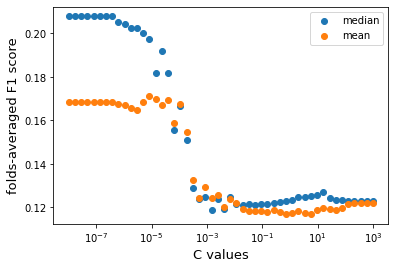

In [ ]:
lrgr_cv.scores_[True].shape
lrgr_cv.get_params()

# print(lrgr_cv.Cs_)
# print(lrgr_cv.scores_[True].mean(axis=0))

plt.scatter(lrgr_cv.Cs_, np.median(lrgr_cv.scores_[True], axis=0));
plt.scatter(lrgr_cv.Cs_, np.mean(lrgr_cv.scores_[True], axis=0));
plt.xlabel('C values', fontsize=13)
plt.ylabel('folds-averaged F1 score', fontsize=13)
plt.xscale('log');
plt.legend(['median', 'mean'], loc='best');

print( f'Max F1 = {np.mean(lrgr_cv.scores_[True], axis=0).max()}')

In [ ]:
y_p = lrgr_cv.predict(X_val)
f1_score(y_val, y_p)

0.15789473684210525

##Catboost

In [88]:
from catboost import CatBoostClassifier, Pool, FeaturesData

RND_SEED = 42

# разбиваем датасет на тренировку и валидацию
features_to_drop = [
                    'smiles',
                    'is_test', 'active'
]
X_cb = data[~data['is_test']].drop(features_to_drop, axis=1)
y_cb = data.loc[~data['is_test'], 'active']

X_cb_train, X_cb_val, y_cb_train, y_cb_val = train_test_split(
    X_cb, y_cb, test_size=0.2, random_state=RND_SEED
)

# X_cb_train_fd= Pool(FeaturesData(
#     num_feature_data = X_cb_train['MW'].values.reshape(-1, 1).astype(np.float32),
#     cat_feature_data = X_cb_train.drop(['MW', 'smiles'], axis=1).values.astype(str),
#     num_feature_names = ['MW'],
#     cat_feature_names = X_cb_train.drop(['MW', 'smiles'], axis=1).columns
# ))

# X_cb_val_pool = Pool(FeaturesData(
#     num_feature_data = X_cb_val['MW'].values.reshape(-1, 1).astype(np.float32),
#     cat_feature_data = X_cb_val.drop(['MW', 'smiles'], axis=1).values.astype(str),
#     num_feature_names = ['MW'],
#     cat_feature_names = X_cb_val.drop(['MW', 'smiles'], axis=1).columns
# ))

cb_clf = CatBoostClassifier(
    loss_function=None,
    eval_metric='F1',
    learning_rate=0.5,
    verbose=False,
    random_seed=None
)

cb_clf.fit(X_cb_train, y_cb_train.astype(str),
        #    text_features=['smiles'],
)
y_pred_cb = cb_clf.predict(X_cb_val)
y_pred_cb = np.asarray([y == 'True' for y in y_pred_cb])

f1_score(y_cb_val.astype('int8'), (y_pred_cb).astype('int8'))
# X_cb_train_pool = 

0.26229508196721313

In [87]:
# get_submission_file(cb_clf, data)

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,False
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,True
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,False
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,False
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,False
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,False
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,False


In [85]:
from catboost import cv

train_pool = Pool(
    data=X_cb,
    label=y_cb.astype(str),
    has_header=True
)



---
---
---
ИДЕИ
---
---

### Визуализация молекулы

In [ ]:
# 616                        O1[As]2O[As]3O[As]1O[As](O2)O3
# 1144                                        O=N[O-].[Na+]
# 1172    O=[Mg].O=[Mg].O=[Mg].O=[Si]=O.O=[Si]=O.O=[Si]=...
# 2569                                            [I-].[K+]
# 2858                         O=P([O-])([O-])F.[Na+].[Na+]
# 6264                                          NS(N)(=O)=O

# 616          O1[As]2O[As]3O[As]1O[As](O2)O3
# 915          CC(=O)Nc1cc([As](=O)(O)O)ccc1O
# 5864     O=[N+]([O-])c1ccc([As](=O)(O)O)cc1
# 6562    O=[N+]([O-])c1cc([As](=O)(O)O)ccc1O
# 6761                Nc1ccc([As](=O)(O)O)cc1

CCC(COC(=O)c1cc(OC)c(OC)c(OC)c1)(c1ccccc1)N(C)C
Unknown


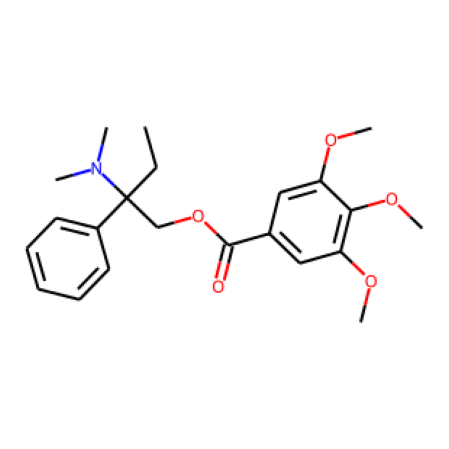

In [ ]:
# smpl = train['smiles'][134]
smpl_ind = 7084
smpl = data.loc[smpl_ind, 'smiles']

# smpl = 'C(-c6cnc7ccccc7c6)'
if_active = 'Active' if data.loc[smpl_ind, 'active'] \
                    else ('Not active' if smpl_ind < 5556 else 'Unknown')

mol = Chem.MolFromSmiles(smpl)
im = Chem.Draw.MolToImage(mol)
print(f'{smpl}\n{if_active}')
plt.figure(figsize = (8, 8))
axs = plt.axes(frameon=True)
axs.imshow(im)
axs.axis('off');

### Визуализируем группу молекул:

IndexError: ignored

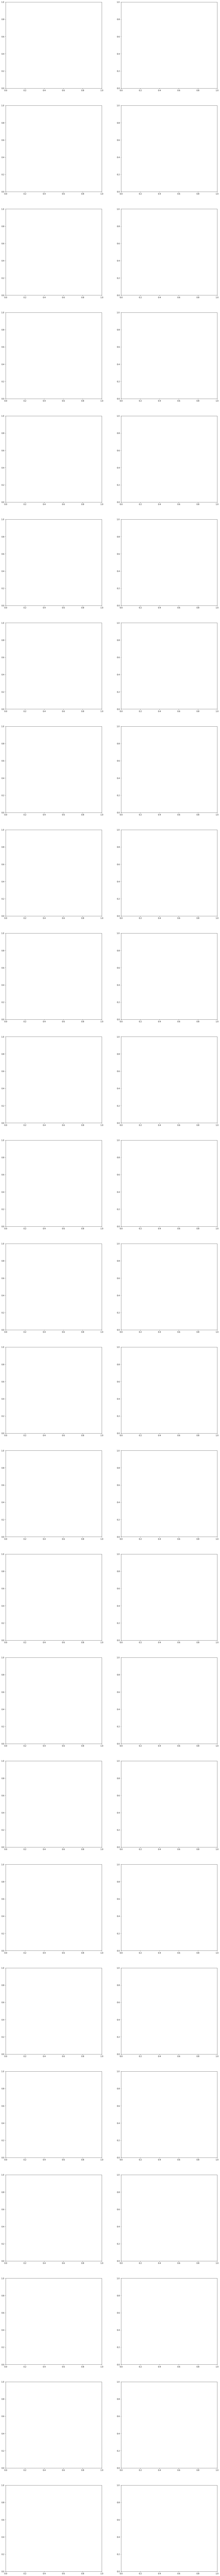

In [ ]:
# samples = train.iloc[active_ind, :]['smiles'].values
start_n = 0
stop_n = 50
n_to_plot = stop_n - start_n
n_plot_rows = n_to_plot // 2 + n_to_plot % 2
# mask_ = data['smiles'].apply(lambda m: any(a in m for a in ['.']))
# samples = data.loc[mask_, ['smiles']][start_n:stop_n]

samples = pd.DataFrame(deleted_salts[start_n:stop_n])

fig, axs = plt.subplots(n_plot_rows, 2, figsize=(20, n_to_plot*5))
axs = (ax for ax in axs.ravel())

for ind in samples.index:
    ax_curr = next(axs)
    smpl = samples.loc[ind, 'smiles']
    mol = Chem.MolFromSmiles(smpl)
    im = Chem.Draw.MolToImage(mol)
    print(f'{ind}) {smpl}')
    # plt.figure(figsize = (3, 3))
    # axs(i) = plt.axes(frameon=True)
    ax_curr.imshow(im)
    ax_curr.set_title(f'{ind}: {smpl}');
    ax_curr.axis('off');

# # удаляем пустой график
# if n_to_plot % 2:
#     ax_curr = next(axs)
#     im = Chem.Draw.MolToImage(Chem.MolFromSmiles('C1CCC1'))
#     ax_curr.imshow(im)
#     fig.delaxes(ax_curr)    
# for ax in axs:    
#     if not(ax.has_data()):
#         fig.delaxes(ax_curr)

In [ ]:
# (data.loc[smpl_ind, 'active'])
mask_ = data['smiles'].apply(lambda m: any(a in m for a in ['.Br', 'Br.','.Cl', 'Cl.', '.I', 'I.']))
samples = data.loc[mask_, 'smiles']
samples.iloc[68]

'CCOC(=O)OC(C)OC(=O)[C@@H]1N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccccc3)[C@H]2SC1(C)C.Cl'

In [ ]:
from rdkit.Chem.SaltRemover import SaltRemover

remover = SaltRemover()
mol = Chem.MolFromSmiles('F.C[N+]1(C)C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2.O=[N+]([O-])[O-].O=C(O)C(=O)O')
res, deleted = remover.StripMolWithDeleted(mol)
# Chem.MolToSmiles(delete[1]), Chem.MolToSmiles(res.])
Chem.MolToSmiles(res)
# deleted[0]

'C[N+]1(C)C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2.F'

### Оцениваем эффект на F1-score от замены y_pred на ~y_pred

In [ ]:
# from sklearn.metrics import f1_score
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# n_sample = 1600
# y_true = np.random.rand(n_sample) >= 0.5
# y_pred = y_true.copy()

# f1 = []
# f1_not = []

# for i in range(3000):
#     ind = np.random.randint(n_sample)
#     if y_pred[ind] == y_true[ind]:
#         y_pred[ind] = not(y_pred[ind])

#     f1 += [f1_score(y_true, y_pred)]
#     f1_not += [f1_score(y_true, ~y_pred)]
   
# # plt.hist(y_true.astype(int));

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.scatter(f1, f1_not);
# plt.xlabel('False F1', fontsize=15);
# plt.ylabel('True F1', fontsize=15);
# plt.plot([0, 1], [1, 0],);

In [ ]:
# mol = Chem.MolFromSmiles('CNNc1ccc(C(O)c2ccccc2)c(O)c1')
# mol = Chem.MolFromSmiles('Nc1nc(O)c2c(n1)NCC(CNc1ccc(C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])cc1)N2C=O.[Ca+2]')
# im = Chem.Draw.MolToImage(mol)

# plt.figure(figsize = (10, 10))
# ax = plt.axes(frameon=True)
# ax.imshow(im)
# ax.axis('off');